In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import scipy as sp
import os, sys,glob, copy
import cPickle as pk
import pandas as pd
import h5py

import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline

sys.path.append("/Users/xiaoxuanj/work/work_allen/Ephys/code_library/ephys_code")

import data_loader as dl
reload(dl)

import matrix_utils as mu
reload(mu)

import functional_clustering as fc
reload(fc)

<module 'functional_clustering' from '/Users/xiaoxuanj/work/work_allen/Ephys/code_library/ephys_code/functional_clustering.pyc'>

# load matrix

In [9]:
mouse_ID='388523'
X = np.load('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/adjacency_matrix/RF_onscreen/mouse'+mouse_ID+'_adjacency_matrix_RF.npy')
df = pd.read_csv('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/meta_cluster_RF_old/mouse'+mouse_ID+'_meta_cluster_RF.csv')
df=mu.add_area_to_df(df)


#cluster = np.load('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/functional_cluster/mouse'+mouse_ID+'_CCG_diff_cluster_labels.npy')
f = '/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/meta_cluster/mouse'+mouse_ID+'_meta_cluster.csv'
df_all = pd.read_csv(f, index_col=0)
df['cluster']=df_all.cluster
# get probe info and separations
areas = df.area.unique().astype(str)

probenames = df.probe_id.unique().astype(str)
separations = [0]
#separations[-1]=separations[-1]-1
for probe in probenames:
    index = np.where(df.probe_id==probe)[0]
    separations = np.concatenate([separations, [index[-1]+1]],axis=0)


In [3]:
df.probe_id.unique()

array(['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF'],
      dtype=object)

# plot connectivity matrix

Text(0.5,1,'Diff of CCG (+/-13 ms) grating')

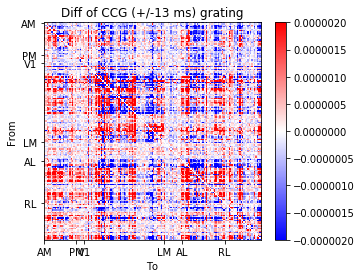

In [28]:
plt.figure(figsize=(5,4))
plt.imshow(X, vmax=0.000002, vmin=-0.000002, cmap='bwr')
plt.xticks(separations[:-1],  areas, fontsize=10)
plt.yticks(separations[:-1],  areas, fontsize=10)
plt.colorbar()
plt.xlabel('To')
plt.ylabel('From')
plt.title('Diff of CCG (+/-13 ms) grating')
#plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/mouse'+mouse_ID+'_connectivity_matrix_grating.pdf')

# plot connectivity matrix: sorted

Text(0,0.5,'To')

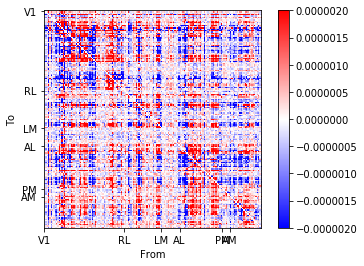

In [6]:
# add new column with grouped area ids
probes = ['probeC', 'probeF','probeD','probeE','probeB','probeA'
        ]
areas = df.area.unique().astype(str)
    
new_index=[]
new_areas=[]
separations = [0]
for a in probes:
    select_idx = np.where(df.probe_id.values==a)[0]
    if len(select_idx)>0:
        new_index.append(select_idx)
        separations = np.concatenate([separations, [separations[-1]+len(select_idx)]],axis=0)
    flat_list = [item for sublist in new_index for item in sublist]

new_areas = ['V1', 'RL', 'LM','AL', 'PM','AM']
plt.imshow(X[np.ix_(flat_list, flat_list)].T, vmax=0.000002, vmin=-0.000002, cmap='bwr')
plt.xticks(separations[:-1],  new_areas, fontsize=10)
plt.yticks(separations[:-1],  new_areas, fontsize=10)
plt.colorbar()
plt.xlabel('From')
plt.ylabel('To')
#plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/mouse'+mouse_ID+'_connectivity_matrix_grating_reordered.pdf')

# clustering connectivity matrix

In [16]:
FC.Z.T.shape

(164, 34)

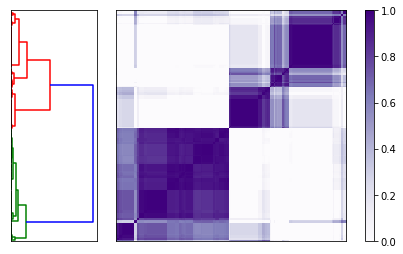

In [29]:
import functional_clustering as fc
reload(fc)


FC = fc.functional_clustering(np.nan_to_num(X))

# normalize and PCA
FC.normalize()
FC.pca()
# plotted cov of connectivity matrix

# probiliaty matrix from kmeans
matrix = FC.probability_matrix(3, data=FC.Z.T)

# hierarchical clustering
FC.linkage()

# plot hierarchical clustering matrix
FC.plot_matrix()

# save output cluster ids
FC.predict_cluster(k=3)
labels= FC.clusters

#f = '/Users/xiaoxuanj/work/work_allen/Ephys/mouse'+mouse_ID+'/'+condi+'_cluster_labels.npy'
#np.save(f, labels)
#plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/mouse'+mouse_ID+'_connectivity_matrix_grating_clustering_dendrogram.pdf')

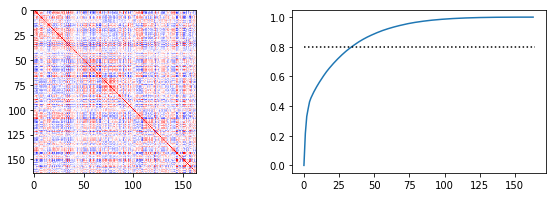

In [10]:
import pca_basic
reload(pca_basic)
pca_basic.pca_basic(FC.X_n, threshold=0.8, plot=True)
plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/mouse'+mouse_ID+'_connectivity_matrix_grating_clustering_pca_ev.pdf')

# determine number of k

In [ ]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.vq import kmeans2
from scipy.cluster.vq import whiten
#from sklearn.cluster import MiniBatchKMeans

# 1. normalization (var=1 in all dims)
Z_n = StandardScaler().fit_transform(np.nan_to_num(FC.Z.T))

n = np.shape(Z_n)[0]

import kmeans_plus
reload(kmeans_plus)

kpp = kmeans_plus.DetK(2, Z_n)
kpp.run(8)


# apply UMAP to visualize PCs

In [38]:
import umap
embedding = umap.UMAP(n_neighbors=3,
                      min_dist=0.4,
                      metric='correlation').fit_transform(FC.Z.T)

In [46]:
df.cluster.unique()

array([1., 3., 2.])

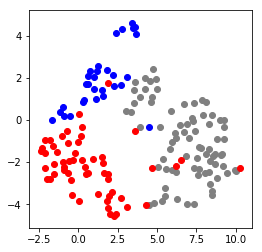

In [64]:
labels = df.cluster.values
#labels= FC.clusters
color=['gray','r', 'b']
plt.figure(figsize=(4,4))
for idx in [1,2,3]:
    plt.scatter(embedding[np.where(labels==idx)[0],0], embedding[np.where(labels==idx)[0],1], c=color[idx-1])
#plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/mouse'+mouse_ID+'_connectivity_matrix_grating_clustering_umap_visualization.pdf')

# plot clustering intermediate steps

In [56]:
import functional_clustering as fc
reload(fc)

FC = fc.functional_clustering(np.nan_to_num(X))


# normalize and PCA
FC.normalize()
FC.pca()
#plt.colorbar()
# plotted cov of connectivity matrix
#plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/func_connect/fc_method/connectivity_matrix_cov.pdf')


In [12]:
from scipy.cluster.vq import kmeans2
# visualize kmeans on pca
clusters = kmeans2(FC.Z.T, 3, iter=1000, thresh=5e-6,minit='random')

In [16]:
labels = clusters[1]

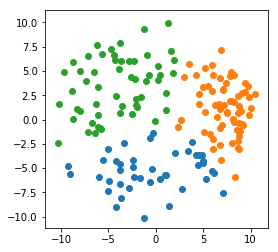

In [20]:
plt.figure(figsize=(4,4))
plt.scatter(FC.Z.T[labels==0,0], FC.Z.T[labels==0,1])
plt.scatter(FC.Z.T[labels==1,0], FC.Z.T[labels==1,1])
plt.scatter(FC.Z.T[labels==2,0], FC.Z.T[labels==2,1])
plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/mouse'+mouse_ID+'_connectivity_matrix_grating_clustering_kmeans_examplePC12.pdf')

In [30]:
# calculate boots of probability matrix
B=[]
for boot in range(10):
    # probiliaty matrix from kmeans
    matrix = FC.probability_matrix(3, data=FC.Z.T)
    B.append(FC.dist)


In [58]:
# PCA reduced matris
reduced = FC.Z.T

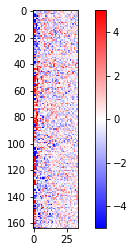

In [59]:
plt.imshow(reduced, cmap='bwr', vmax=5, vmin=-5)
plt.colorbar()
#plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/mouse'+mouse_ID+'_connectivity_matrix_grating_clustering_pca.pdf')

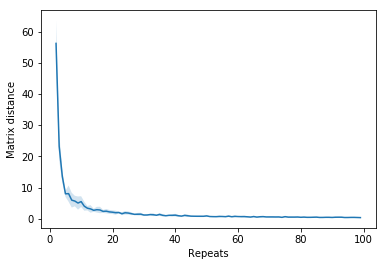

In [60]:
B=np.array(B)
mu = B.mean(0)
std = B.std(0)
plt.plot(np.arange(100), mu, )
plt.fill_between(np.arange(100), mu-std, mu+std, alpha=0.2)
plt.ylabel('Matrix distance')
plt.xlabel('Repeats')
plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/mouse'+mouse_ID+'_connectivity_matrix_grating_clustering_convergence.pdf')

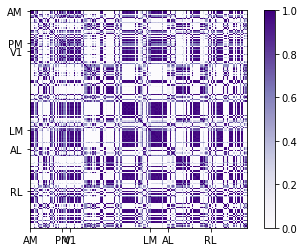

In [31]:
plt.imshow(FC.matrix, cmap='Purples')
plt.xticks(separations[:-1],  areas, fontsize=10)
plt.yticks(separations[:-1],  areas, fontsize=10)
plt.colorbar()
plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/mouse'+mouse_ID+'_connectivity_matrix_grating_clustering_probability_unsorted_matrix_purple.pdf')


In [63]:
np.linalg.norm(FC.matrix-(FC.matrix*0.5))

45.17475401150515